In [1]:
# -*- coding: utf-8 -*-
#This cell is created to convert GH raw point info into class objects with adjancency status
#Originally written in Spyder, do not run this cell unless necessary

"""
Created on Thu Feb 25 15:18:57 2021

@author: Henan.Liu
"""


import openpyxl
import numpy as np
import scipy.spatial as spatial

#loc = r"D:/WFH2020/210202_IOC/RL/Spreadsheet/Raw.xlsx"
loc = r"X:/henan.liu/__ML/Spreadsheet/0504_Raw.xlsx"
rawFile = openpyxl.load_workbook(loc)
rawSheet = rawFile.active
maxRow = rawSheet.max_row

lst = []
ptLst = []
#print (rawSheet[1])

for i in range(maxRow):
    subList = []
    for cell in rawSheet[i+1]:
        cell = cell.value
        if cell:
            cell = cell[1:-1].split(",")
            cell = cell[:-1]
            subList.append([float(stuff) for stuff in cell])
    lst.append(subList)

class point():
    def __init__(self,row,num,pos,length):
        self.pos = pos
        self.row = row
        self.num = num
        self.length = length
        self.neighbor = []
        
    def assign(self, indexN):
        self.neighbor.append(indexN)
        
final_List = []
parallel_List = []
for i,row in enumerate(lst):
    subList = []
    for j,pt in enumerate(row):
        obj = point(i,j,np.asarray(pt),len(row))
        ptLst.append(obj.pos)
        subList.append(obj)
        parallel_List.append(obj)
    final_List.append(subList)
ptArray = np.asarray(ptLst)

for i, row in enumerate(final_List):
    print (i)
    for j, pt in enumerate(row):
        point_tree = spatial.cKDTree(ptArray)
        point_index = point_tree.query_ball_point(pt.pos, 1000)
        for index in point_index:
            
            pt.assign([parallel_List[index].row,parallel_List[index].num])
              

#Writing worksheet
wb = openpyxl.Workbook()
ws = wb.active
for i, row in enumerate(final_List):
    for j, pt in enumerate(row):     
        
        ws.cell(row = i+1, column = j+1).value= str([pt.row, pt.num, pt.pos.tolist(), pt.length, pt.neighbor])
newloc = r"X:/henan.liu/__ML/Spreadsheet/0504_Product.xlsx"
wb.save(newloc)
#dist = np.linalg.norm(ptArray[1] - ptArray[2])
#print (ptArray.shape)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215


In [2]:
from scipy.spatial import distance
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import ast
import math

#Read spreadsheet
loc = r"X:/henan.liu/__ML/Spreadsheet/0504_Product.xlsx"
wb = openpyxl.load_workbook(loc)
ws = wb.active
lstManual = [4,3,2,1]

#Initialize objects
class seat():
    def __init__(self,row,num,pos,length,indexN,NO):
        self.pos = pos
        self.state = 0
        self.row = row
        self.num = num
        self.length = length
        self.indexN = indexN
        self.NO = NO
        
    def assign(self, state):
        self.state = state
        
    def refresh(self):
        self.state = 0
        
lstSeat = []
Flat_lstSeat = []

NO = 0
for i,row in enumerate(ws):
    rowTemp = []
    for j, num in enumerate(row):
        if num.value:
            value_list = ast.literal_eval(num.value)
            pos = value_list[2]
            length = value_list[3]
            indexN = value_list[4]
            obj = seat(i,j,pos,length,indexN,NO)
            rowTemp.append(obj)
            Flat_lstSeat.append(obj)
            NO += 1

    lstSeat.append(rowTemp)

In [3]:
#Creating Environment
class environment():
    def __init__(self,lstManual,lstSeat,Flat_lstSeat):
        self.row = 0
        self.num = 0
        self.lstManual = lstManual
        self.lstSeat = lstSeat
        self.done = False        
        self.map = np.zeros([len(lstSeat),len(max(lstSeat,key = lambda x: len(x))),1])
        #self.map = np.zeros(len(Flat_lstSeat))
        #self.map = np.reshape(self.map, (-1,1))
        self.count_total = 0
        self.OBSERVATION_SPACE_VALUES = (self.map.shape)
        self.ACTION_SPACE_SIZE = 5
        self.total = sum(len(sub) for sub in lstSeat)
        self.reward = 0
        self.detect_legal()
        self.occupied = 0
        
    def detect_legal(self):
        clear = 1
        for i,pLine in enumerate(self.lstSeat[self.row:],start =self.row):
            for j, pt in enumerate(pLine):
                for k, opt in enumerate(self.lstManual):
                    if j + opt <= len(pLine):
                        clear = 0
                        for u in range(opt):
                            if pLine[j + u].state!=0:
                                clear += 1
                    if clear == 0:
                        self.max_opt = opt
                        self.row = i
                        self.num = j
                        break
                if clear ==0:
                    break
            if clear ==0:
                break
        if clear != 0:
            self.done = True

    def move(self,action):
        self.detect_legal()
        if action>self.max_opt:
            print ("Environemnt Warning: illegal move, too big an action")
            
        elif action == 0:
            self.lstSeat[self.row][self.num].assign(0.2)
            self.map[self.row][self.num][0] = 0.1
            #index =  self.lstSeat[self.row][self.num].NO
            #self.map[index][0] = 0.2
            self.occupied += 1
            self.reward = 0
            
        else:
            self.count_total += action
            self.occupied += action
            self.reward = action/4
            for u in range(action):
                self.lstSeat[self.row][self.num + u].assign(action)
                index =  self.lstSeat[self.row][self.num + u].NO
                #self.map[index][0] = action
                self.map[self.row][self.num + u][0] = action #Used to be = action
                
            for u in range(action):
                index_list = self.lstSeat[self.row][self.num + u].indexN
                for index in index_list:
                    if self.lstSeat[index[0]][index[1]].state == 0:
                        self.lstSeat[index[0]][index[1]].assign(0.1)
                        self.map[index[0]][index[1]][0] = 0.1
                        #mapIndex = self.lstSeat[index[0]][index[1]].NO
                        #self.map[mapIndex][0] = 0.1
                        self.occupied += 1
                        #self.reward -= 1
        self.detect_legal()
        #self.reward = self.count_total / self.occupied
        #if env.done:
            #self.reward = self.count_total - 90
            
    def check(self):
        obs_list = []
        for pLine in self.lstSeat:
            for pt in pLine:
                obs_list.append(pt.state) 
        return np.array(obs_list)

    def reset(self):
        for thing in self.lstSeat:
            for stuff in thing:
                stuff.refresh()
                
        self.done = False
        #self.map[:] = 0
        self.map = np.zeros([len(lstSeat),len(max(lstSeat,key = lambda x: len(x))),1])
        self.count_total = 0
        self.row = 0
        self.num = 0
        self.reward = 0
        self.occupied = 0
        self.detect_legal()
        #return self.map
        
env = environment(lstManual, lstSeat, Flat_lstSeat)

1035
(216, 13, 1)


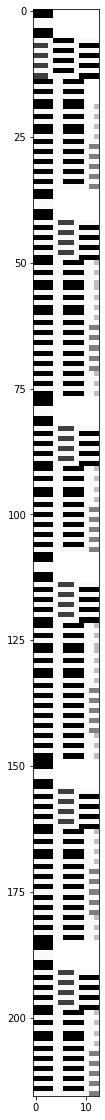

In [17]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
env.reset()
test01 = env.map
while not env.done:
    action = env.max_opt
    #print ("A",env.max_opt)
    #print (action)
    env.move(action)
    #print ("B",env.max_opt)
    #print (env.reward)
#print (env.map/4)
#env.reset()
print (env.count_total)
print (env.OBSERVATION_SPACE_VALUES)
#print (env.map)
img = env.map/4
img = np.reshape(img, (216, 13))
#res = cv2.resize(img, dsize=(60,60), interpolation=cv2.INTER_CUBIC)
plt.figure(figsize = (216,20))
plt.imshow(img,cmap=plt.cm.binary)
#plt.show()
#env.reset()

In [ ]:
import numpy as np
import keras
import keras.backend.tensorflow_backend as backend
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten, Conv1D
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import tensorflow as tf
from collections import deque
import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

REPLAY_MEMORY_SIZE = 100000
MIN_REPLAY_MEMORY_SIZE = 5000
MODEL_NAME = "Seating_Layout"
MINIBATCH_SIZE = 32
DISCOUNT = 1
UPDATE_TARGET_EVERY= 10
EPISODES = 10000
PLOT_EVERY = 50

# Exploration settings
epsilon = 0.9  
EPSILON_DECAY = epsilon/(EPISODES//3)
MIN_EPSILON = 0.1

#Plotting
plotting = [[],[],[]]

# Agent class
class DQNAgent:
    def __init__(self):

        # Main model
        self.model = self.create_model()
        
        #Load Model
        #self.model.load_weights('X:/henan.liu/__ML/Weights/Model_V4_0_154_C')
        #self.model = keras.models.load_model('D:/WFH2020/210202_IOC/RL/TrainingModel/Model_V3_7_G')
        #self.target_model = keras.models.load_model('D:/WFH2020/210202_IOC/RL/TrainingModel/Model_V3_7_G')
        
        # Target network
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        # An array with last n steps for training
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        
        #Load Memory
        #self.replay_memory = pickle.load( open( 'X:/henan.liu/__ML/Pickle/Model_V4_0_154_B', 'rb' ) )
        
        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0

    def create_model(self):
        
        model = Sequential()
        
        #model.add(Conv1D(32, 26, strides = 2, activation = 'relu', input_shape=env.OBSERVATION_SPACE_VALUES)) 
        
        #model.add(Conv1D(64, 12, strides = 1, activation = 'relu'))
        
        #model.add(Conv1D(64, 3, strides = 1, activation = 'relu'))
        
        #model.add(Flatten())
        
        #model.add(Dense(512,activation = "relu"))
        
        #model.add(Dense(env.ACTION_SPACE_SIZE, activation='linear'))

        model.add(Conv2D(16, 4, strides = 2,padding = 'same', input_shape=env.OBSERVATION_SPACE_VALUES, data_format='channels_last')) 
        model.add(Activation('relu'))

        model.add(Conv2D(32, 3, strides = 1,padding = 'same'))
        model.add(Activation('relu'))
        
        #model.add(Conv2D(64, 3, strides = 1,padding = 'same'))
        #model.add(Activation('relu'))
        
        model.add(Flatten()) 
        model.add(Dense(256,activation = "relu"))

        model.add(Dense(env.ACTION_SPACE_SIZE, activation='linear')) 
        
        model.compile(loss=keras.losses.Huber(), optimizer=Adam(lr=0.00025))
        return model

    # Adds step's data to a memory replay array
    # (observation space, action, reward, new observation space, done)
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    # Trains main network every step during episode
    def train(self, terminal_state):
                
        # Start training only if certain number of samples is already saved
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return
        
        # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/4
        current_qs_list = self.model.predict(current_states)

        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3] for transition in minibatch])/4
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []
        
        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, done, step,episode,new_opt) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[index][:new_opt])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward
                
            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)
        
        # Fit on all samples as one batch, log only on terminal state
        if terminal_state:
            self.model.fit(np.array(X)/4, np.array(y), batch_size=MINIBATCH_SIZE, verbose=2, shuffle=False)
        else:
            self.model.fit(np.array(X)/4, np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False)
        
        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1
            print ("future qs list[0] = ",future_qs_list[0], "Step = ", minibatch[0][5],"Episode = ", minibatch[0][6] )
            print ("future qs list[1] = ",future_qs_list[1], "Step = ", minibatch[1][5],"Episode = ", minibatch[1][6] )
            #print ("future qs list[2] = ",future_qs_list[2], "Step = ", minibatch[2][5],"Episode = ", minibatch[2][6] )
            #print ("future qs list[3] = ",future_qs_list[3], "Step = ", minibatch[3][5],"Episode = ", minibatch[3][6] )
            
        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0
            print ("Target Model is updated")

    # Queries main network for Q values given current observation space (environment state)
    def get_qs(self, state):
        return self.model.predict(state.reshape(-1, *state.shape)/4)[0]
        
agent = DQNAgent()

move_LIST = []
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):
    
    episode_reward = 0
    step = 0
    env.reset()
    current_state = np.copy(env.map)
    move_list = []
    while not env.done:
        
        opt = env.max_opt+1
        if np.random.random()> epsilon:
            
            action = np.argmax(agent.get_qs(current_state)[:opt])
            
        else:
            action = np.random.randint(0, opt)
        
        move_list.append(action)
        env.move(action)
        new_state = np.copy(env.map)
        reward = env.reward
        done = env.done
        new_opt = env.max_opt + 1
        episode_reward += reward
        
        if env.done:
            print (episode_reward,  env.count_total,  epsilon)
            
            #if env.count_total>= 1060:
               # move_LIST.append(move_list)
        #if env.count_total > 400:
            #agent.model.save_weights('D:/WFH2020/210202_IOC/RL/TrainingModel/Model_V3_7_H')
            #print ("A very cool model is saved")
            
        agent.update_replay_memory((current_state, action, reward, new_state, done, step, episode, new_opt))
        agent.train(done)
        
        current_state = new_state
        step += 1
          
    if epsilon > MIN_EPSILON:
        epsilon -= EPSILON_DECAY
    
    plotting[0].append(episode)
    plotting[1].append(env.count_total)
    plotting[2].append(episode_reward)
    
    if episode % PLOT_EVERY == 0:
        xpoints = np.array(plotting[0])
        ypoints = np.array(plotting[1])
        xpoints = np.mean(xpoints.reshape(-1, 5), axis=1)
        ypoints = np.mean(ypoints.reshape(-1, 5), axis=1)
        plt.plot(xpoints, ypoints)
        plt.show()
    

In [19]:
agent.model.save_weights('X:/henan.liu/__ML/Weights/Model_V4_1_2457_B')

In [108]:
import pickle

outfile = open('X:/henan.liu/__ML/Pickle/Model_V4_1_2457_A','wb')
pickle.dump(agent.replay_memory,outfile)
outfile.close()

In [87]:
memory = pickle.load( open( 'X:/henan.liu/__ML/Pickle/Model_V4_0_154_B', 'rb' ) )
print (type(memory))

<class 'collections.deque'>


In [33]:
import numpy as np
lstSum = [sum(stuff) for stuff in lst]
print (lstSum)
print (lst[6])

[63, 60, 61, 61, 60, 60, 66, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60]
[0, 0, 0, 4, 0, 0, 3, 4, 4, 3, 4, 4, 3, 4, 4, 3, 4, 4, 3, 4, 4, 3, 4]


In [35]:
env.reset()
step = 0
while not env.done:
    
    action = lst[6][step]
    env.move(action)
    step+= 1
print (env.count_total)


66


In [18]:
import openpyxl
from openpyxl import Workbook

newloc = r"X:/henan.liu/__ML/Spreadsheet/0506_Machine.xlsx"
newloc2 = r"X:/henan.liu/__ML/Spreadsheet/0506_Dummy.xlsx"
newloc3 = r"X:/henan.liu/__ML/Spreadsheet/0506_Machine_FullBase.xlsx"
wb = Workbook()
ws = wb.active
for i,stuff in enumerate(Flat_lstSeat):
    #print (Flat_lstSeat[i].pos)
    ws.cell(row = i+1, column = 1).value = Flat_lstSeat[i].pos[0]
    ws.cell(row = i+1, column = 2).value = Flat_lstSeat[i].pos[1]
    ws.cell(row = i+1, column = 4).value = Flat_lstSeat[i].state
wb.save(newloc2)

In [ ]:
count = 0
for thing in agent.replay_memory:
    if thing[2]!=0:
        count += 1
print (count)
print (len(agent.replay_memory))

In [ ]:
#print (np.sum(agent.replay_memory[1][0]))
state1 =  (agent.replay_memory[2][0])
state2 =  (agent.replay_memory[5000][0])
print (np.sum(agent.replay_memory[2][0]))
print (np.sum(agent.replay_memory[5000][0]))
a = agent.model.predict(state1.reshape(-1, *state1.shape)/4)[0]
b = agent.model.predict(state2.reshape(-1, *state2.shape)/4)[0]
print (a)
print (b)

In [14]:
model = agent.model
#model.load_weights('D:/WFH2020/210202_IOC/RL/TrainingModel/Model_V4_0_Large')
#model.set_weights(agent.target_model.get_weights())
env.reset()
#print (env.max_opt)
#model = agent.model
step = 0
count = 0
while not env.done:
    state = env.map
    q_table = model.predict(np.array(state).reshape(-1, *state.shape)/4)[0]
    a = env.max_opt
    action = np.argmax(q_table[:env.max_opt+1])
    print (q_table)
    print (np.max(q_table[:env.max_opt+1]), "step = ", step)
    
    print (a,action)
    env.move(action)
    step += 1
    
    #print ("count = ",count)
#plt.imshow(env.map.reshape(12,13)/4,cmap=plt.cm.binary)
#plt.show()
print (env.count_total)
#env.reset()

[275.14117 275.12225 275.10233 275.2752  275.48358]
275.48358 step =  0
4 4
[274.1834  274.23676 274.4075  274.5864  274.74646]
274.74646 step =  1
4 4
[273.209   273.22723 273.26477 273.42865 273.61792]
273.61792 step =  2
4 4
[272.2533  272.13324 272.21362 272.40848 272.60825]
272.60825 step =  3
4 4
[271.5743  271.38144 271.29788 271.48172 271.77902]
271.77902 step =  4
4 4
[270.32202 270.15607 270.45578 270.71555 270.8125 ]
270.71555 step =  5
3 3
[269.65067 269.3585  269.41135 269.58566 269.78406]
269.78406 step =  6
4 4
[268.78265 268.56134 268.5385  268.67407 268.92957]
268.92957 step =  7
4 4
[267.60428 267.55426 267.81143 268.05872 268.1461 ]
268.05872 step =  8
3 3
[266.93796 266.86594 266.93    267.09003 267.27872]
267.27872 step =  9
4 4
[266.2045  265.8321  265.928   266.11337 266.33783]
266.33783 step =  10
4 4
[264.8597  264.7811  265.07898 265.25223 265.39786]
265.25223 step =  11
3 3
[264.20248 263.94513 264.02567 264.21356 264.40555]
264.40555 step =  12
4 4
[263.3334

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




3 2
[6.1001635 5.752891  5.7889385 6.0381613 6.3341684]
6.3341684 step =  350
4 4
[5.0388155 5.0385437 5.3098497 5.237028  5.3443546]
5.3443546 step =  351
4 4
[3.9960783 3.923573  4.2567863 4.2435217 4.2822614]
4.2567863 step =  352
2 2
[3.5008194 3.0657706 3.1380017 3.426208  3.7250795]
3.7250795 step =  353
4 4
[2.7462485 2.268437  2.3792748 2.3860312 2.3403435]
2.7462485 step =  354
4 0
[2.7447503 2.2793999 2.349829  2.31647   2.268027 ]
2.7447503 step =  355
4 0
[2.7302375 2.1647072 2.04552   2.1063867 2.2158291]
2.7302375 step =  356
4 0
[2.7348595 2.1548603 2.096592  2.2440133 2.3644643]
2.7348595 step =  357
4 0
[2.5822659 2.2099311 2.2969174 2.5049095 2.7217467]
2.7217467 step =  358
4 4
[1.5232882 1.3702471 1.5293615 1.7417244 1.7217208]
1.7417244 step =  359
3 3
[0.73691326 0.5673262  0.57287824 0.74788356 1.0189244 ]
1.0189244 step =  360
4 4
1101


In [ ]:
print (agent.replay_memory[0])

1081


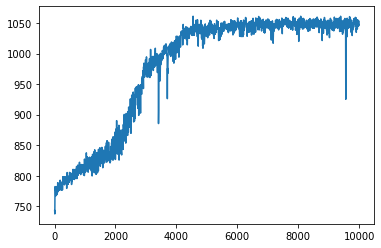

909


In [13]:
import matplotlib.pyplot as plt

xpoints = np.array(plotting[0])
ypoints = np.array(plotting[1])
print (np.max(plotting[1]))
xpoints = np.mean(xpoints.reshape(-1, 5), axis=1)
ypoints = np.mean(ypoints.reshape(-1, 5), axis=1)
plt.plot(xpoints, ypoints)
plt.savefig('X:/henan.liu/__ML/Plot/Model_V4_1_2457_B_5.pdf')
plt.show()
print (np.argmax(ypoints))
